- v5 is started on 6th December 2022, just after examinations
- It is meant to recap on what has been done and try to implement Datagen
- Without the use of Datagen, the server keeps crashing due to memory overflow

In [5]:
import re
# import cv2

import nrrd
import random
import os, glob
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from patchify import patchify, unpatchify

import keras
import tensorflow as tf
from keras import backend as K
from keras.models import Model
from tensorflow.keras import layers
from keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, CSVLogger
from keras.layers import Activation, MaxPool2D, Concatenate
from tensorflow.keras.utils import plot_model

from ipywidgets import interact, interactive, IntSlider, ToggleButtons

In [ ]:
print(tf.keras.__version__)
print(tf.__version__)
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices[3])
# tf.config.experimental.set_memory_growth(physical_devices[3], True)
os.environ["CUDA_VISIBLE_DEVICES"]="3"
# tf.config.experimental.set_memory_growth(physical_devices[1], True)

In [ ]:
data_dir = '/home/tester/jianhoong/jh_fyp_work/ct_scans_data/raw_data/'

z_train = os.path.join(data_dir, 'training_data_z')
z_train_image = os.path.join(z_train, 'training_images/training_images')
z_train_mask = os.path.join(z_train, 'training_masks/training_masks')

z_valid = os.path.join(data_dir, 'valid_data_z')
z_valid_image = os.path.join(z_valid, 'valid_images/valid_images')
z_valid_mask = os.path.join(z_valid, 'valid_masks/valid_masks')

z_test = os.path.join(data_dir, 'testing_data_z')
z_test_image = os.path.join(z_test, 'testing_images/testing_images')
z_test_mask = os.path.join(z_test, 'testing_masks/testing_masks')

In [ ]:
# Defining Helper Functions
def read_nrrd_file(filepath):
    '''read and load volume'''
    pixelData, header = nrrd.read(filepath)
    return pixelData[:,:,:96]

def normalize(volume):
    min = -1000 # min value of our data : -1000
    max = 5000 # max value of our data : 5013
    range = max - min
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / range
    volume = volume.astype("float32")
    return volume

def process_scan(path):
    volume = read_nrrd_file(path)
    volume = normalize(volume)
    return volume

def sorted_alnum(l):
    convert = lambda text: int(text) if text.isdigit() else text 
    alphanum_key = lambda key : [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(l, key = alphanum_key)

def training_generator():
    train_dir = '/home/tester/jianhoong/jh_fyp_work/ct_scans_data/raw_data/training_data_z/training_images/training_images'
    train_mask_dir = '/home/tester/jianhoong/jh_fyp_work/ct_scans_data/raw_data/training_data_z/training_masks/training_masks'

    train_data_with_96 = [15, 16, 20, 21, 23, 33, 37, 52, 64, 69, 72, 76, 77, 83, 92, 94, 95, 97, 103, 116, 123, 129, 157, 159, 162, 163, 170, 171, 180, 191, 192, 198, 200, 207, 209]
    
    train_path = sorted_alnum([os.path.join(train_dir, file) for file in os.listdir(train_dir)  if int(re.findall(r'\d+', file)[0]) in train_data_with_96])
    train_mask_path = sorted_alnum([os.path.join(train_mask_dir, file) for file in os.listdir(train_mask_dir)  if int(re.findall(r'\d+', file)[0]) in train_data_with_96])
    
    for i in range(len(train_path)):
        x = process_scan(train_path[i])
        y = read_nrrd_file(train_mask_path[i])
        
        yield x,y
        
def validation_generator(valid_path, valid_mask):
    
    valid_dir = '/home/tester/jianhoong/jh_fyp_work/ct_scans_data/raw_data/valid_data_z/valid_images/valid_images'
    valid_mask_dir = '/home/tester/jianhoong/jh_fyp_work/ct_scans_data/raw_data/valid_data_z/valid_masks/valid_masks'

    valid_data_with_96 = [213, 219, 221, 227, 231, 238, 240, 243, 249, 250, 255, 256, 257, 270]

    valid_path = sorted_alnum([os.path.join(valid_dir, file) for file in os.listdir(valid_dir)  if int(re.findall(r'\d+', file)[0]) in valid_data_with_96])
    valid_mask_path = sorted_alnum([os.path.join(valid_mask_dir, file) for file in os.listdir(valid_mask_dir)  if int(re.findall(r'\d+', file)[0]) in valid_data_with_96])
    
    for i in range(len(valid_path)):
        x = process_scan(valid_path[i])
        y = read_nrrd_file(valid_mask_path[i])
        yield x, y
        

In [ ]:
train_loader = tf.data.Dataset.from_generator(training_generator,(tf.float32, tf.float32))
validation_loader = tf.data.Dataset.from_generator(validation_generator,(tf.float32, tf.float32))

ds = train_loader.batch(10)

train_dataset = train_loader.shuffle(4)
train_dataset = train_dataset.apply(tf.data.experimental.ignore_errors())
train_dataset = train_dataset.batch(2, drop_remainder=True).prefetch(8)

valid_dataset = validation_loader.shuffle(4)
valid_dataset = valid_dataset.apply(tf.data.experimental.ignore_errors())
valid_dataset = valid_dataset.batch(2, drop_remainder=True).prefetch(8)

In [2]:
def conv_block(input, num_filters):
    x = Conv3D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv3D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPooling3D((2, 2, 2))(x)
    return x, p   

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv3DTranspose(num_filters, (2, 2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:  #Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv3D(n_classes, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [3]:
# Loss Function and coefficients to be used during training:
def dice_coefficient(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    smoothing_factor = 1.0
    flat_y_true = K.flatten(y_true)
    flat_y_pred = K.flatten(y_pred)
    return (2. * K.sum(flat_y_true * flat_y_pred) + smoothing_factor) / (K.sum(flat_y_true) + K.sum(flat_y_pred) + smoothing_factor)

def dice_coefficient_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    return 1.0 - dice_coefficient(y_true, y_pred)

#Define parameters for our model.
n_classes = 1
patch_size = 32
channels=3

LR = 0.001
opt = tf.keras.optimizers.Nadam(LR)


model = build_unet((64,64,32,3), n_classes = 1)
model.compile(optimizer = opt, loss=dice_coefficient_loss, metrics=dice_coefficient)
print(model.summary())

sigmoid
Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 32,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 64, 64, 32,   5248        ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 32,   256        ['conv3d[0][0]']                 
 alization)                     64)                                                   

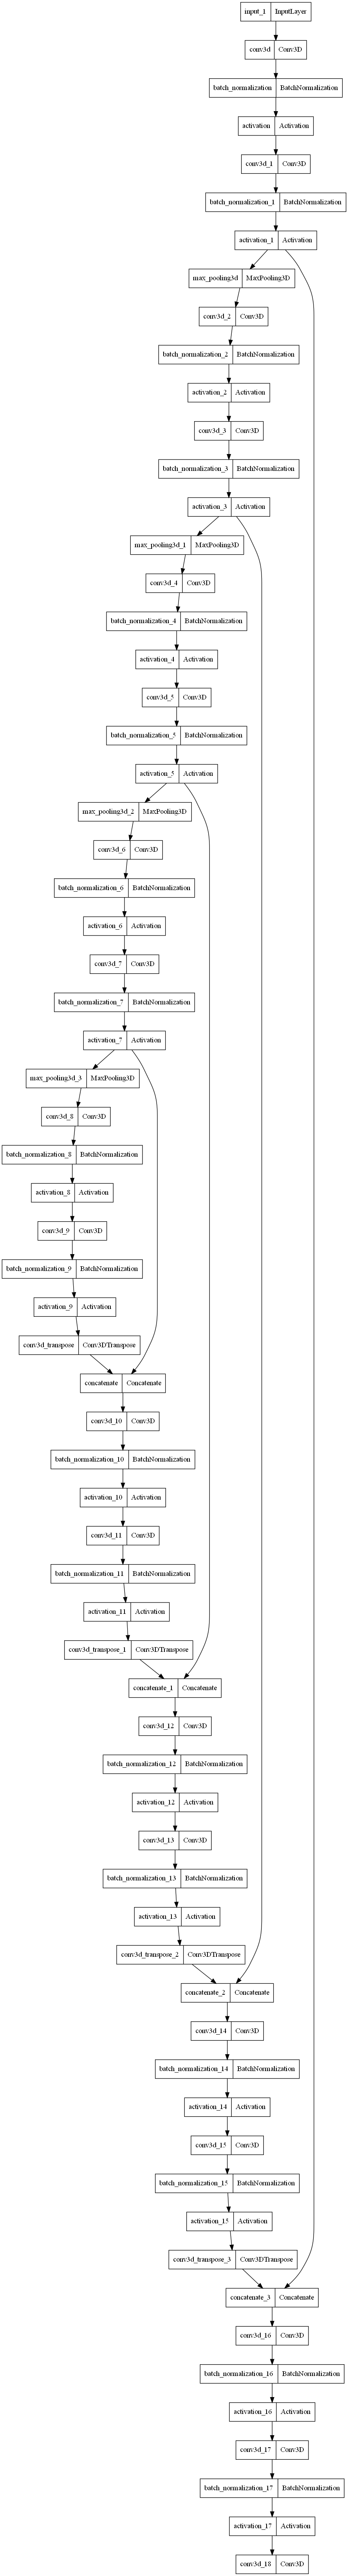

In [6]:
plot_model(model, to_file='v5_simpleUNet.png')

In [ ]:
csv_path = '/home/tester/jianhoong/jh_fyp_work/3D_UNet/trials/3DUNet_ModelCSVLogs/UNet_Approach3_v5.csv'
model_checkpoint_path = '/home/tester/jianhoong/jh_fyp_work/3D_UNet/ModelCheckpoints/Approach3_v5.hdf5'

my_callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True),
    CSVLogger(csv_path, separator = ',', append = True),
    ModelCheckpoint(filepath = model_checkpoint_path,
    monitor = 'val_loss',
    mode = 'min',
    verbose = 1)
]

In [ ]:
# data = train_dataset.take(1)
# images, labels = list(data)[0]
# images = images.numpy()
# image = images[0]
# print("Dimension of the CT scan is:", image.shape)
# plt.imshow(np.squeeze(image[:, :, 30]), cmap="gray")

In [ ]:
print(model.input_shape)
# print(train_data.shape)
print(model.output_shape)
# print(train_mask.shape)
print("-------------------")
# print(train_data.max())  

In [ ]:
#Fit the model
history = model.fit(
        train_dataset, 
        validation_data = valid_dataset,
        epochs=50,
        shuffle = True,
        verbose=2,
        callbacks = my_callbacks)

In [ ]:
# These are the patients with 3mm thickness CT Scan and have mask labels within first 96 slices
# These data are generated from "ct_scans_data" directory -> "understanding_CTSCAN.ipynb"
# Take note that not all patients have up to 96 slices, thus the smaller cubes may not amount to 96 slice

train_data = [4,5,9,10,15,16,18,19,20,21,22,23,28,29,33,34,35,37,44,51,52,58,64,68,69,72,73,76,77,79,82,83,90,91,92,93,94,95,97,103,104,116,123,126,129,131,134,136,139,142,149,151,155,157,159,162,163,164,169,170,171,179,180,186,188,191,192,198,200,201,206,207,208,209]
valid_data = [213,214,215,217,219,220,221,224,226,227,228,231,237,238,240,243,248,249,250,254,255,256,257,264,266,270]
test_data = [271,272,274,277,280,283,286,287,288,293,294,296,297,298,300,303,305,306,314,315,317,320,322,340,342,345,347]

train_data_with_96 = [15, 16, 20, 21, 23, 33, 37, 52, 64, 69, 72, 76, 77, 83, 92, 94, 95, 97, 103, 116, 123, 129, 157, 159, 162, 163, 170, 171, 180, 191, 192, 198, 200, 207, 209]
valid_data_with_96 = [213, 219, 221, 227, 231, 238, 240, 243, 249, 250, 255, 256, 257, 270]
test_data_with_96 = [271, 272, 274, 277, 283, 286, 287, 293, 296, 300, 303, 305, 306, 314]

In [ ]:
# train_path = sorted_alnum([os.path.join(z_train_image, file) for file in os.listdir(z_train_image)  if int(re.findall(r'\d+', file)[0]) in train_data])
# train_mask_path = sorted_alnum([os.path.join(z_train_mask, file) for file in os.listdir(z_train_mask)  if int(re.findall(r'\d+', file)[0]) in train_data])

# valid_path = sorted_alnum([os.path.join(z_valid_image, file) for file in os.listdir(z_valid_image)  if int(re.findall(r'\d+', file)[0]) in valid_data])
# valid_mask_path = sorted_alnum([os.path.join(z_valid_mask, file) for file in os.listdir(z_valid_mask)  if int(re.findall(r'\d+', file)[0]) in valid_data])

# test_path = sorted_alnum([os.path.join(z_test_image, file) for file in os.listdir(z_test_image)  if int(re.findall(r'\d+', file)[0]) in test_data])
# test_mask_path = sorted_alnum([os.path.join(z_test_mask, file) for file in os.listdir(z_test_mask)  if int(re.findall(r'\d+', file)[0]) in test_data])

train_path = sorted_alnum([os.path.join(z_train_image, file) for file in os.listdir(z_train_image)  if int(re.findall(r'\d+', file)[0]) in train_data_with_96])
train_mask_path = sorted_alnum([os.path.join(z_train_mask, file) for file in os.listdir(z_train_mask)  if int(re.findall(r'\d+', file)[0]) in train_data_with_96])

valid_path = sorted_alnum([os.path.join(z_valid_image, file) for file in os.listdir(z_valid_image)  if int(re.findall(r'\d+', file)[0]) in valid_data_with_96])
valid_mask_path = sorted_alnum([os.path.join(z_valid_mask, file) for file in os.listdir(z_valid_mask)  if int(re.findall(r'\d+', file)[0]) in valid_data_with_96])

test_path = sorted_alnum([os.path.join(z_test_image, file) for file in os.listdir(z_test_image)  if int(re.findall(r'\d+', file)[0]) in test_data_with_96])
test_mask_path = sorted_alnum([os.path.join(z_test_mask, file) for file in os.listdir(z_test_mask)  if int(re.findall(r'\d+', file)[0]) in test_data_with_96])

In [ ]:
def process_all(scan_paths, mask_paths):
    """
    Processes all training ct scan cubes ~ 46000 cubes currently
    """
    scan_store = np.zeros((1,64,64,32)) # Initialize 1 cube of size (32 x 32 x 32) full of zeroes as np.array cannot concatenate without same dimension
    mask_store = np.zeros((1,64,64,32))

    for i in range(len(scan_paths)):
        scan_pixelData = process_scan(scan_paths[i])
        mask_pixelData = read_nrrd_file(mask_paths[i])

        scan_patch = patchify(scan_pixelData, (64,64,32), step = 16) # Yield 15 x 15 x 3 of size 64 x 64 x 32 cubes
        mask_patch = patchify(mask_pixelData, (64,64,32), step = 16)

        input_img = np.reshape(scan_patch, (-1, scan_patch.shape[3], scan_patch.shape[4], scan_patch.shape[5])) # Collapse 15 x 15 x 3 into 675 cubes x 64 x 64 x 32
        input_mask = np.reshape(mask_patch, (-1, mask_patch.shape[3], mask_patch.shape[4], mask_patch.shape[5]))

        scan_store = np.append(scan_store, input_img, axis = 0)
        mask_store = np.append(mask_store, input_mask, axis = 0)

        print(scan_store.shape)
        print(mask_store.shape)
    return scan_store[1:,:], mask_store[1:,:] # Don't return the first index which is the initialized 0 empty array


def get_cubes(all_scan_cubes, all_mask_cubes, BACKBONE,desired_size = 300):
    scan_storage = list()
    mask_storage = list()

    while len(scan_storage) < desired_size:
        if len(scan_storage) > desired_size:
            break
        random_idx = random.randint(0, len(all_scan_cubes)-1)
        if np.sum(all_mask_cubes[random_idx]) > 0:
            scan_storage.append(all_scan_cubes[random_idx])
            mask_storage.append(all_mask_cubes[random_idx])
            print(f'cube {random_idx} stored', ' : ', f' Current samples: {len(scan_storage)}')

    scan_storage = np.array(scan_storage)
    mask_storage = np.array(mask_storage)

    processed_scan = np.stack((scan_storage,)*3, axis=-1)
    processed_mask = np.expand_dims(mask_storage, axis=4)

    preprocess_input = sm.get_preprocessing(BACKBONE)
    return preprocess_input(processed_scan), processed_mask

In [ ]:
all_scans, all_masks = process_all(train_path, train_mask_path)

In [ ]:
def process_one(scan_paths, mask_paths,desired_size = 300):
    scan_storage = list()
    mask_storage = list()
    patients_processed = list()

    while len(scan_storage) < desired_size:
        
        random_idx = random.randint(0, len(scan_paths)-1)
        patient_idx = int(re.findall(r'\d+', scan_paths[random_idx][-14:-11])[0]) # Extracting patient number from path name
        patients_processed.append(patient_idx) # Extract numerical patient index from path string

        print(f'Processing Patient {patient_idx} data')
        scan_pixelData = process_scan(scan_paths[random_idx]) # process_scan includes normalizing
        mask_pixelData = read_nrrd_file(mask_paths[random_idx]) # Don't need to normalize mask

        scan_patch = patchify(scan_pixelData, (64,64,32), step = 32) # Yield 15 x 15 x 3 of size 64 x 64 x 32 cubes
        mask_patch = patchify(mask_pixelData, (64,64,32), step = 32)

        input_img = np.reshape(scan_patch, (-1, scan_patch.shape[3], scan_patch.shape[4], scan_patch.shape[5])) # Collapse 15 x 15 x 3 into 675 cubes x 64 x 64 x 32
        input_mask = np.reshape(mask_patch, (-1, mask_patch.shape[3], mask_patch.shape[4], mask_patch.shape[5])) # 675 x 64 x 64 x 32
        
        # processed_scan = np.stack((input_img,)*3, axis=-1) # Becomes 675 x 64 x 64 x 32 x 3
        # processed_mask = np.expand_dims(input_mask, axis=3) # Becomes 675 x 64 x 64 x 32 x 1 

        for i in range(input_mask.shape[0]): # Iterate through every small cubes
            if np.sum(input_mask[i]) > 0: # Extract small cubes where mask present
                if len(scan_storage) >= desired_size:
                    break
                print(f'Storing Patient {patient_idx} data, Cube Num: {i}')
                scan_storage.append(input_img[i])
                mask_storage.append(input_mask[i])
                print(f'Current Training Data: {len(scan_storage)}')

    # scan_storage = np.array(scan_storage)
    # mask_storage = np.array(mask_storage)
    
    # processed_scan = np.stack((scan_storage,)*3, axis=-1)
    # processed_mask = np.expand_dims(mask_storage, axis=4)
    
    return scan_storage, mask_storage, patients_processed

def check_patients_processed(processed_patients_list):
    x = Counter(processed_patients_list)
    top = 5
    if len(processed_patients_list) == len(set(processed_patients_list)):
        print(f"No duplicates of patients processed detected. {len(processed_patients_list)} patients processed")
    else:
        print(f'Total patients processed: {len(processed_patients_list)}')
        print(f"Unique Patients processed: {len(set(processed_patients_list))}")
        print(f"Top {top} occuring patients: ")
        for i in range(top):
            print(f"Patient {x.most_common()[i][0]} : {x.most_common()[i][1]} times ")

In [ ]:
train_data, train_mask, train_patients = process_one(train_path, train_mask_path, 1500)

In [ ]:
# Visualizing 1 small cube for sense check
@interact
def explore_prediction(layer = (0,31), view = ["axial", "sagittal","coronal"]):
    if view == 'axial':
        img_array_view = train_data[0][layer, :, :]
        msk_array_view = train_mask[0][layer, :, :]
    elif view == 'coronal':
        img_array_view = train_data[0][:,layer,:]
        msk_array_view = train_mask[0][:,layer,:]
    else:
        img_array_view = train_data[0][:,:,layer]
        msk_array_view = train_mask[0][:,:,layer]

    plt.figure(figsize=(18, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img_array_view, cmap='gray', aspect = "auto")
    plt.title('Img', fontsize=10)
    plt.subplot(1, 2, 2)
    plt.imshow(msk_array_view, cmap='gray', aspect = "auto")
    plt.title('Mask', fontsize=10)
    plt.subplot(1, 2, 1)
    plt.show()

In [ ]:
valid_data, valid_mask, valid_patients = process_one(valid_path, valid_mask_path, 300)

In [ ]:
train_data = np.array(train_data)
train_mask = np.array(train_mask)
valid_data = np.array(valid_data)
valid_mask = np.array(valid_mask)

In [ ]:
train_data.shape

In [ ]:
train_data = np.stack((train_data,)*3, axis=-1)
valid_data = np.stack((valid_data,)*3, axis=-1)

train_mask = np.expand_dims(train_mask, axis=4)
valid_mask = np.expand_dims(valid_mask, axis=4)

In [ ]:
train_data.shape

In [ ]:
# Loss Function and coefficients to be used during training:
def dice_coefficient(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    smoothing_factor = 1.0
    flat_y_true = K.flatten(y_true)
    flat_y_pred = K.flatten(y_pred)
    return (2. * K.sum(flat_y_true * flat_y_pred) + smoothing_factor) / (K.sum(flat_y_true) + K.sum(flat_y_pred) + smoothing_factor)

def dice_coefficient_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    return 1.0 - dice_coefficient(y_true, y_pred)

#Define parameters for our model.
n_classes = 1
patch_size = 32
channels=3

LR = 0.001
opt = tf.keras.optimizers.Nadam(LR)


model = build_unet((64,64,32,3), n_classes = 1)
model.compile(optimizer = opt, loss=dice_coefficient_loss, metrics=dice_coefficient)
print(model.summary())

In [ ]:
csv_path = '/home/tester/jianhoong/jh_fyp_work/3D_UNet/trials/3DUNet_ModelCSVLogs/UNet_Approach3_v5.csv'
model_checkpoint_path = '/home/tester/jianhoong/jh_fyp_work/3D_UNet/ModelCheckpoints/Approach3_v5.hdf5'

my_callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True),
    CSVLogger(csv_path, separator = ',', append = True),
    ModelCheckpoint(filepath = model_checkpoint_path,
    monitor = 'val_loss',
    mode = 'min',
    verbose = 1)
]

In [ ]:
#Fit the model
history = model.fit(train_data, 
        train_mask,
        batch_size=2, 
        epochs=50,
        verbose=1,
        validation_data=(valid_data, valid_mask),
        callbacks = my_callbacks)